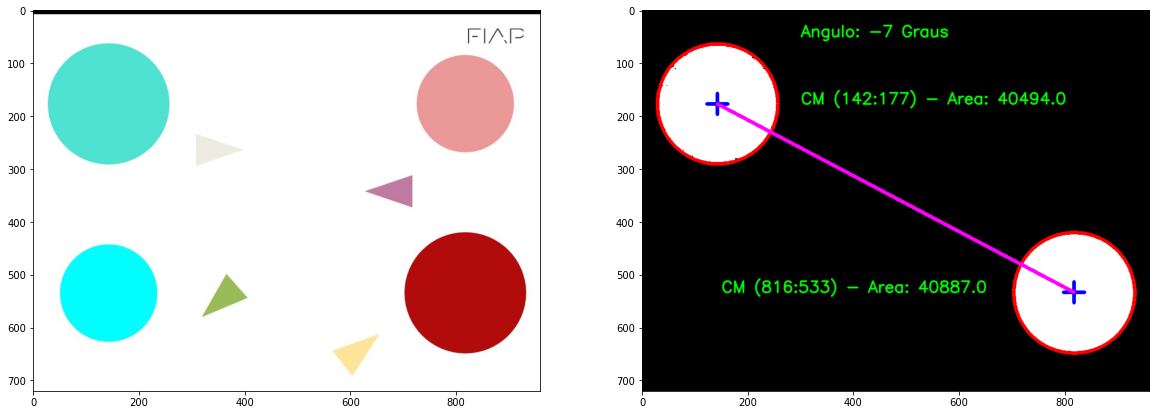

In [18]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline

image = cv2.imread("assets/circulo.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 1º Intervalo de cores de matiz vermelha
lower_hsv_red = np.array([170, 128, 128])
upper_hsv_red = np.array([179, 255, 255])

# 2º Intervalo de cores de matiz vermelha
lower_hsv_red_2 = np.array([0, 128, 128])
upper_hsv_red_2 = np.array([7, 255, 255])

# Intervalo de cores de matiz ciano
lower_hsv_cyan = np.array([82, 128, 128])
upper_hsv_cyan = np.array([87, 255, 255])

# Função que filtra as cores da imagem de acordo com os intervalos de cor indicados 
def apply_color_filter(image_bgr, lower_hsv, upper_hsv):
    img_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, lower_hsv, upper_hsv)
    return mask

# Função que renderiza um texto na imagem final
def write_text(image, text, window_margin, color):
    font_family = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, str(text), window_margin, font_family, 1, color, 2, cv2.LINE_AA)

# Função que renderiza uma cruz no centro de massa dos círculos detectados 
def draw_circle_center(image, cX, cY, size, color):
    cv2.line(image, (cX - size, cY), (cX + size, cY), color, 5)
    cv2.line(image, (cX, cY - size), (cX, cY + size), color, 5) 

# Função que calcula o angulo de inclinação dos círculos detectados com o plano horizontal da imagem final
def calculate_horizontal_angle(cX1, cY1, cX2, cY2):
    rad = math.atan2(cY1 - cY2, cX1 - cX2)
    angle = round(rad * 180 / math.pi)
    return angle

# Máscaras da imagem final, após a filtragem de cores
mask_hsv_red = apply_color_filter(image, lower_hsv_red, upper_hsv_red)
mask_hsv_red_2 = apply_color_filter(image, lower_hsv_red_2, upper_hsv_red_2)
mask_hsv_cyan = apply_color_filter(image, lower_hsv_cyan, upper_hsv_cyan)

# Aplica as máscaras de matiz vermelha em uma única máscara
mask_hsv_reds = cv2.bitwise_or(mask_hsv_red, mask_hsv_red_2)

# Máscara utilizada para tratar a imagem final
mask_hsv = cv2.bitwise_or(mask_hsv_reds, mask_hsv_cyan)

# Contornos detectados na imagem filtrada
contours, _ = cv2.findContours(mask_hsv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Imagem convertida para RGB
mask_rgb = cv2.cvtColor(mask_hsv, cv2.COLOR_GRAY2RGB)
output = mask_rgb.copy()

# Contorno e valor da área do maior círculo detectado
higher = None
higher_area = 0

# Contorno e valor da área do segundo maior círculo detectado
second_higher = None
second_higher_area = 0

# Verifica e classifica os maiores círculos detectados
for c in contours:
    area = cv2.contourArea(c)
    
    if area > higher_area:
      second_higher_area = higher_area
      higher_area = area
      second_higher = higher
      higher = c
    elif area > second_higher_area:
      second_higher_area = area
      second_higher = c    

# Dimensões dos contornos de cada círculo
M1 = cv2.moments(higher)
M2 = cv2.moments(second_higher)

# Verifica se ao menos 2 círculos foram detectados corretamente, caso contrário, renderiza 
# uma mensagem informando que nada foi detectado 
if M1["m00"] != 0 and M2["m00"] != 0:
    
    # Dimensões do maior círculo convertidas para inteiro
    cX1 = int(M1["m10"] / M1["m00"])
    cY1 = int(M1["m01"] / M1["m00"])
    
    # Dimensões do segundo maior círculo convertidas para inteiro
    cX2 = int(M2["m10"] / M2["m00"])
    cY2 = int(M2["m01"] / M2["m00"])

    # Renderiza o contorno, o centro de massa e o valor da área do maior círculo
    cv2.drawContours(output, [higher], -1, [255, 0, 0], 5)
    draw_circle_center(output, cX1, cY1, 20, (0, 0, 255))
    text = "CM (" + str(cX1) + ":" + str(cY1) + ") - Area: " + str(higher_area)
    if cX1 > 200:
        write_text(output, text, (150, cY1), (0, 255, 0))
    else:
        write_text(output, text, (300, cY1), (0, 255, 0))

    # Renderiza o contorno, o centro de massa e o valor da área do segundo maior círculo
    cv2.drawContours(output, [second_higher], -1, [255, 0, 0], 5)
    draw_circle_center(output, cX2, cY2, 20, (0, 0, 255))
    text = "CM (" + str(cX2) + ":" + str(cY2) + ") - Area: " + str(second_higher_area)
    if cX2 > 200: 
        write_text(output, text, (150, cY2), (0, 255, 0))
    else:
        write_text(output, text, (300, cY2), (0, 255, 0))


    # Traça uma linha entre os centros de massa dos maiores círculos
    cv2.line(output, (cX1, cY1), (cX2, cY2), (255, 0, 255), 5)

    # Calcula e renderiza o ângulo de inclinação e renderiza na imagem final
    angle = calculate_horizontal_angle(cX1, cX2, cY1, cY2)
    text = "Angulo: " + str(angle) + " Graus"
    write_text(output, text, (300, 50), (0, 255, 0))

else:
    text = "Nada foi detectado"
    write_text(output, text, (300, 50), (255, 0, 0))

fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.show()